In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    QuantileTransformer,
)
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
import warnings

warnings.filterwarnings("ignore")

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Загрузим датасет и посмотрим, какие признаки он содержит.

In [3]:
prefix = "/kaggle/input/animal-shelter-log/"

import platform

if platform.system() == "Windows":
    prefix = "data/"
else:
    prefix = "data\\"

train = pd.read_csv(prefix + "train.csv", encoding="utf-8")
data_test = pd.read_csv(prefix + "test.csv", encoding="utf-8")
train.head(5)

,Name,SexuponOutcome,AnimalType,AgeuponOutcome,Breed,Color,DateTime,Outcome,ID
0,Socks,Neutered Male,Cat,2 months,Domestic Shorthair Mix,Black/White,2014-06-11 14:36:00,0,0
1,Vera,Intact Female,Cat,1 month,Domestic Shorthair Mix,Tortie/White,2014-07-18 08:10:00,3,1
2,Biscuit,Neutered Male,Dog,3 months,Chihuahua Shorthair Mix,Yellow,2016-01-02 17:28:00,2,2
3,Kitten,Spayed Female,Cat,2 years,Domestic Shorthair Mix,Calico,2014-02-19 17:27:00,0,3
4,NaN,Neutered Male,Cat,2 months,Domestic Shorthair Mix,Orange Tabby,2014-07-21 17:34:00,0,4


Определим две функции для работы с временными данными: одна из них будет кодировать дату, а другая -- время исхода. Такой выбор основан на том, что могут быть сезоны(например, праздники) когда животных чаще забирают из приютов, а также на том, что исходы могут иметь свое распределение в пределах одного дня(мало кто захочет забрать/усыпить животное в 3 утра).

In [4]:
def pandas_dates2number(date_series: pd.Series):
    return pd.to_datetime(date_series).values.astype(np.int64) // 10**9

In [5]:
def pandas_times2number(date_series: pd.Series):
    dts = pd.to_datetime(date_series).dt
    return dts.hour.values.astype(np.int64) * 3600 +  dts.minute.values.astype(np.int64) * 60 + dts.second.values.astype(np.int64)

Будет логичным преобразовать возраст животного на момент исхода из строки в числа, так как у людей, забирающих животных из приютов, возможно есть предпочтения по возрасту.

In [6]:
def string_to_age(string):
    if not isinstance(string, str):
        return string
    N, unit = string.split(" ")
    if unit == "year" or unit == "years":
        unit = 365.0
    elif unit == "month" or unit == "months":
        unit = 30
    elif unit == "week" or unit == "weeks":
        unit = 7
    else:
        unit = 1
    return float(N) * unit

Будущим хозяевам также важно знать, способно ли животное производить потомство или нет, поэтому стоит создать отдельную фичу, отражающую эту информацию.

In [7]:
def fertility_check(string):
    if string == "Unknown":
        return False
    str1 = string.split(" ")[0]
    if str1 == "Intact":
        return True
    else:
        return False

In [8]:
def sex_check(string):
    if string == "Unknown":
        return string
    return string.split(" ")[1]

In [9]:
train.Breed.value_counts()

Breed
Domestic Shorthair Mix                          6153
Pit Bull Mix                                    1318
Chihuahua Shorthair Mix                         1225
Labrador Retriever Mix                           984
Domestic Medium Hair Mix                         590
                                                ... 
Pekingese/Chihuahua Shorthair                      1
English Shepherd Mix                               1
Collie Rough/Chinese Sharpei                       1
American Pit Bull Terrier/Labrador Retriever       1
Chihuahua Longhair/West Highland                   1
Name: count, Length: 1145, dtype: int64

In [10]:
train.Breed.value_counts().value_counts()

count
1     597
2     158
3      68
4      56
5      44
     ... 
55      1
59      1
76      1
33      1
29      1
Name: count, Length: 77, dtype: int64

Большое количество расцветок и пород у животных встречаются лишь единожды или дважды на всем датасете, поэтому было бы разумным убрать наименее распространенные окрасы и породы из наших данных.

In [11]:
common_breeds = train.Breed.value_counts()[train.Breed.value_counts() > 2].index
common_colors = train.Color.value_counts()[train.Color.value_counts() > 2].index

In [12]:
def clean_dataframe(df):

    df.index = df.ID

    df["Breed"] = df.Breed.map(lambda x: x if x in common_breeds else "Other")
    df["Color"] = df.Color.map(lambda x: x if x in common_colors else "Other")

    # У этого поля уже есть категория Unknown, поэтому все пропуски заполняем ей
    df["SexuponOutcome"].fillna("Unknown", inplace=True)
    
    df["IsFertile"] = df["SexuponOutcome"].map(lambda x: fertility_check(x))
    df["SexuponOutcome"] = df["SexuponOutcome"].map(lambda x: sex_check(x))

    df["Time"] = pandas_times2number(df.DateTime)
    df["DateTime"] = pandas_dates2number(df.DateTime)
    df["AgeuponOutcome"] = df.AgeuponOutcome.map(lambda x: string_to_age(x))
    median = df["AgeuponOutcome"][df["AgeuponOutcome"].notna()].median()
    df["AgeuponOutcome"].fillna(median, inplace=True)

    # Разделяем животных на возрастные группы. Кошки и собаки имеют примерно одинаковые
    # продолжительности жизни и скорость взросления, поэтому за источник была взята
    # таблица из сайта https://thecatdoctor.co.uk/cat-health/feline-life-stages/

    bins = [-1, 180, 730, 3650, np.inf]
    labels = ["juvenile", "young", "adult", "old"]
    df["AgeGroup"] = pd.cut(df["AgeuponOutcome"], bins=bins, labels=labels)

    return df.drop(["ID", "Name"], axis=1)

In [13]:
train = clean_dataframe(train)
data_test = clean_dataframe(data_test)

In [14]:
train.head()

,SexuponOutcome,AnimalType,AgeuponOutcome,Breed,Color,DateTime,Outcome,IsFertile,Time,AgeGroup
ID,,,,,,,,,,
0,Male,Cat,60.0,Domestic Shorthair Mix,Black/White,1402497360,0,False,52560,juvenile
1,Female,Cat,30.0,Domestic Shorthair Mix,Tortie/White,1405671000,3,True,29400,juvenile
2,Male,Dog,90.0,Chihuahua Shorthair Mix,Yellow,1451755680,2,False,62880,juvenile
3,Female,Cat,730.0,Domestic Shorthair Mix,Calico,1392830820,0,False,62820,young
4,Male,Cat,60.0,Domestic Shorthair Mix,Orange Tabby,1405964040,0,False,63240,juvenile


In [15]:
train.Breed.value_counts()

Breed
Domestic Shorthair Mix                        6153
Pit Bull Mix                                  1318
Chihuahua Shorthair Mix                       1225
Labrador Retriever Mix                         984
Other                                          913
                                              ... 
Rat Terrier/Beagle                               3
Jack Russell Terrier/Australian Cattle Dog       3
Rat Terrier/Cardigan Welsh Corgi                 3
Jindo Mix                                        3
Siberian Husky/German Shepherd                   3
Name: count, Length: 391, dtype: int64

<Axes: >

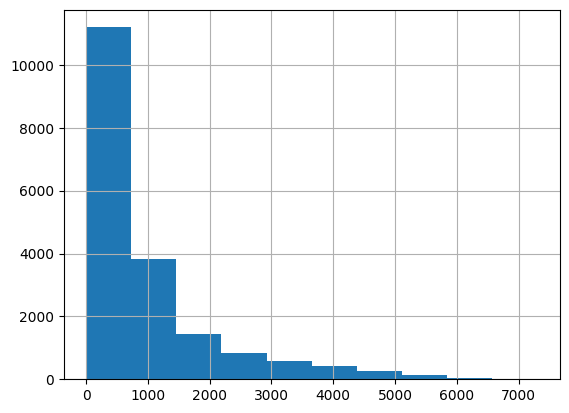

In [16]:
train.AgeuponOutcome.hist()

In [17]:
train.AgeuponOutcome.median()

np.float64(365.0)

<Axes: >

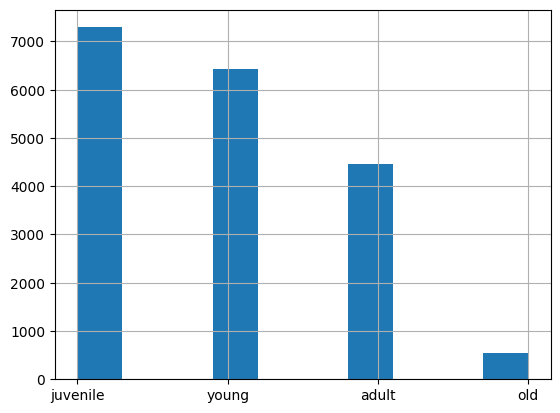

In [18]:
train.AgeGroup.hist()

<Axes: >

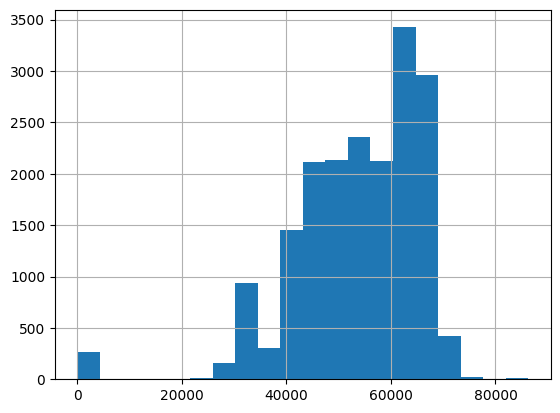

In [19]:
train.Time.hist(bins=20)

<Axes: >

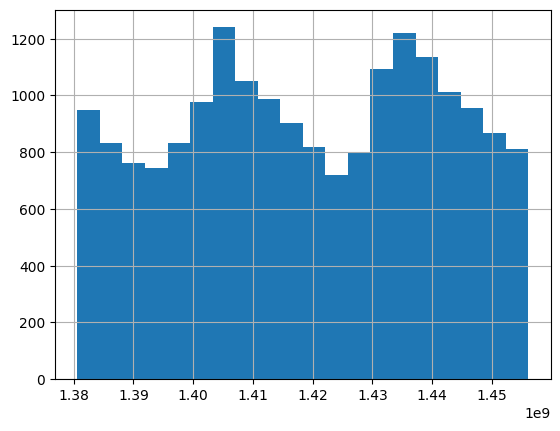

In [20]:
train.DateTime.hist(bins=20)

Для преобразования дат используем ```QuantileTransformer```, т.к. эти данные имеют периодическую природу(т.е. распределены мультимодально), время исхода и возраст на момент исхода могут быть приведены к стандратному распределению. Остальные признаки были закодированы ординально, т.к. при таком кодировании ```HistGradientBoostingClassifier``` работает гораздо лучше([источник](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html)).

In [21]:
cat_cols = ["IsFertile", "SexuponOutcome", "AnimalType", "AgeGroup", "Breed", "Color"]
std_cols = ["AgeuponOutcome", "Time"]
quantile_cols = ["DateTime"]

column_transformer = ColumnTransformer(
    transformers=[
        (
            "ore",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            cat_cols,
        ),
        ("standard_scaling", StandardScaler(), std_cols),
        ("quantile_scaling", QuantileTransformer(random_state=RANDOM_SEED), quantile_cols),
    ],
    remainder="passthrough",
)

In [22]:
y_train = train["Outcome"]
data_train = train.drop(["Outcome"], axis=1)

  File "C:\Users\anaki\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7538
           1       0.98      0.95      0.96      6595
           2       0.95      0.96      0.95      3350
           3       0.91      0.95      0.93      1089
           4       0.89      0.97      0.93       138

    accuracy                           0.96     18710
   macro avg       0.94      0.96      0.95     18710
weighted avg       0.96      0.96      0.96     18710

0.9637092463923036


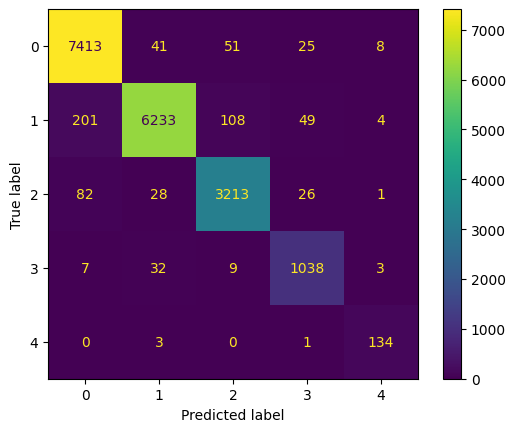

In [23]:
hgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            HistGradientBoostingClassifier(
                class_weight="balanced",
                random_state=RANDOM_SEED,
            ),
        ),
    ]
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            RandomForestClassifier(
                class_weight="balanced",
                random_state=RANDOM_SEED,
                n_estimators=1000,
            ),
        ),
    ]
)

voting_model = VotingClassifier(
    estimators=[
        ("hgb", hgb_pipeline),
        ("rf", rf_pipeline),
    ],
    voting="soft",
    n_jobs=-1,
)

y_pred = voting_model.fit(data_train, y_train).predict(data_train)
print(classification_report(y_train, y_pred))
print(accuracy_score(y_train, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred))

disp.plot()
plt.show()

In [24]:
preds = voting_model.predict(data_test)

# Create a submission using constant predictions
submission = pd.DataFrame({"ID": data_test.index, "Outcome": preds})

# Save the submission
submission.to_csv("submission.csv", index=False)
# submission.to_csv("/kaggle/working/submission.csv", index=False)